First we want to isolate the cementum region. We can (hopefully) do this by performing fits to the mean intensity along the y-axis

In [1]:
%load_ext autoreload
%autoreload 2

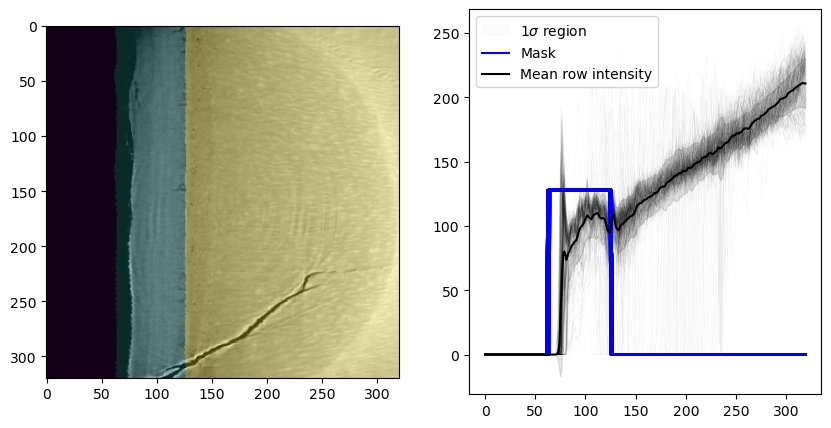

In [2]:
"""
First we'll need the straightened image and mask

"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

image = np.load("straightened_image.npy")
mask = np.load("straightened_mask.npy")

axes[0].imshow(image, cmap="gray")
axes[0].imshow(mask, alpha=0.3)

for im_row, mask_row in zip(image, mask):
    axes[1].plot(im_row, color="k", alpha=0.1, linewidth=0.1)
    axes[1].plot(mask_row * 128, color="b", label="mask")

axes[1].plot(np.mean(image, axis=0), color="k")

axes[1].fill_between(
    np.arange(image.shape[1]),
    np.mean(image, axis=0) - np.std(image, axis=0),
    np.mean(image, axis=0) + np.std(image, axis=0),
    color="k",
    alpha=0.1,
)

axes[1].legend(
    handles=[
        Patch(color="k", alpha=0.01),
        Line2D([], [], color="b"),
        Line2D([], [], color="k"),
    ],
    labels=[rf"1$\sigma$ region", "Mask", "Mean row intensity"],
)

fig.savefig("img/intensity_profile.png")

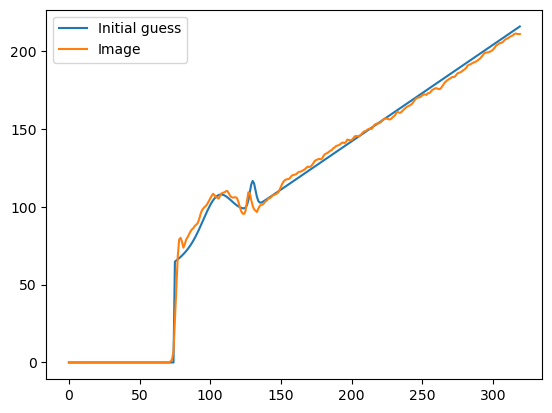

In [3]:
"""
We can try to fit a function to it that gives the positions of the start and end of the cementum region

There will be a constant, a wide Gaussian for the inside of the cementum region, a narrow gaussian for the end of the cementum region 

"""
from scipy.stats import norm

from cementum import fit_cementum_extra_peak, fit_cementum

# Just plot it for now so we can see what it looks like
x = np.arange(image.shape[0])

# initial_guess = [75, 18, 50, 3, 2, 600, 22, 10, 85, 27, 2, 0.62]
initial_guess = [75, 18, 600, 30, 10, 85, 25, 2, 0.62]

y = fit_cementum.fit_fcn(x, *initial_guess)

plt.plot(x, y, label="Initial guess")
plt.plot(x, np.mean(image, axis=0), label="Image")

plt.legend()
plt.savefig("img/fit_fcn.png")

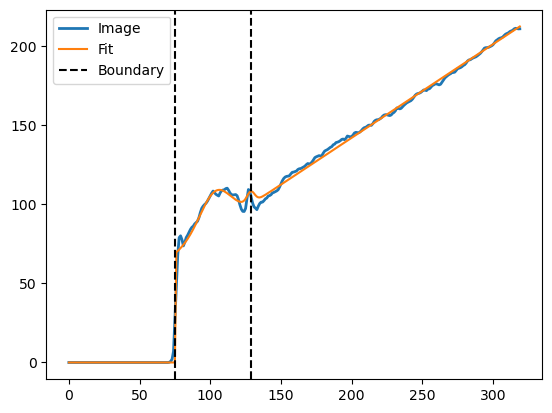

In [4]:
"""
Fit to the mean intensity across the rows

"""
popt = fit_cementum._fit_curve(x, np.mean(image, axis=0), initial_guess)

plt.plot(x, np.mean(image, axis=0), label="Image", linewidth=2)
plt.plot(x, fit_cementum.fit_fcn(x, *popt), label="Fit", linewidth=1.5)

a, d1, d2 = [popt[i] for i in [0, 3, 6]]
start, end = a, a + d1 + d2

plt.axvline(start, color="k", linestyle="--", label="Boundary")
plt.axvline(end, color="k", linestyle="--")

plt.legend()

plt.savefig("img/one_image_fit.png")


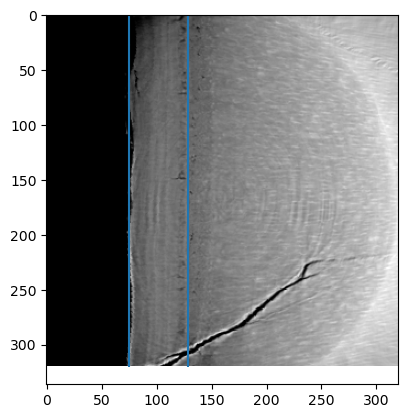

In [5]:
"""
Show the fitted edges on the image

"""

plt.imshow(image, cmap="gray")
plt.vlines(start, 0, image.shape[0])
plt.vlines(end, 0, image.shape[0])

plt.savefig("img/one_image_fit_on_image.png")

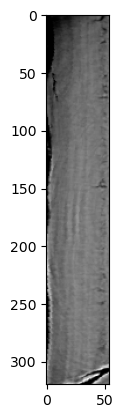

In [6]:
"""
Set the rest of the image to black

"""
cropped_image = image[:, int(start) : int(end) + 1]

plt.imshow(cropped_image, cmap="gray")

Next we want to remove any noise from the columns. We expect the columns to closely follow the layers, so we will remove any peaking noise from them.

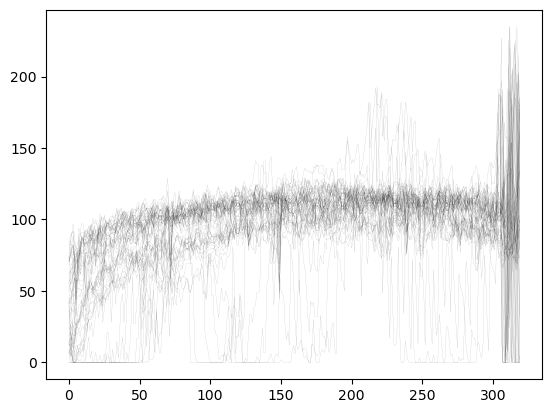

In [7]:
"""
Plot the intensity along columns of the cropped image

"""
fig, axis = plt.subplots()

x = np.arange(cropped_image.shape[0])
for column in cropped_image.T:
    axis.plot(x, column, color="k", alpha=0.4, linewidth=0.1)

You can (sort of?) see the two different types of layer in this image. We might want to remove the curve:

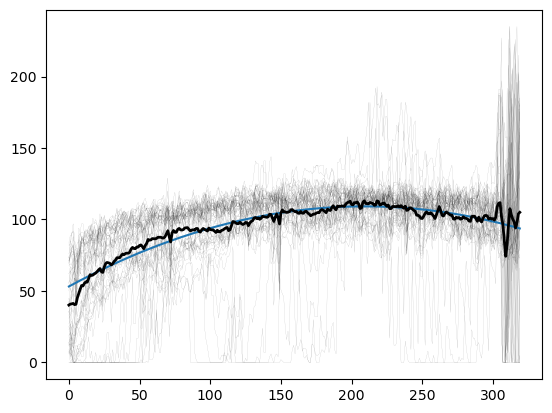

In [8]:
"""
Fit a polynomial to the average columns

"""
fig, axis = plt.subplots()

deg = 2
x = np.arange(cropped_image.shape[0])

for column in cropped_image.T:
    axis.plot(x, column, color="k", alpha=0.4, linewidth=0.1)

coefs = coefs = np.polyfit(x, np.mean(cropped_image, axis=1), deg=deg)
poly_vals = np.polyval(coefs, x)
axis.plot(x, poly_vals)
axis.plot(x, np.mean(cropped_image, axis=1), color="k", linewidth=2)

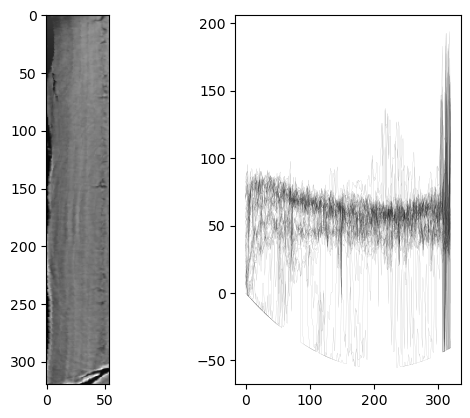

In [9]:
"""
Flatten the curves!

"""
fig, axes = plt.subplots(1, 2)

# Don't remove the constant term
normalised_image = cropped_image - np.polyval(coefs, x).reshape(-1, 1) + coefs[-1]
axes[0].imshow(normalised_image, cmap="grey")

for column in normalised_image.T:
    axes[1].plot(x, column, color="k", alpha=0.4, linewidth=0.1)


We may want to perform contrast normalisation here: create a histogram of the intensity, it should be bimodal

Now that we have removed the noise from the columns, we can apply a vertical Gaussian filter that will help to distinguish the edges.

Now that we've increased the contrast between columns, we can perform fits to isolate the increments